In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import tensorflow as tf
import keras as K
import sklearn as sk
import matplotlib.pyplot as plt

import cv2
import shutil
import os
import warnings

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
from skimage.morphology import label
from tqdm import tqdm

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Global Variables

In [2]:
TRAIN_PATH = './input/stage1_train/'
TEST_PATH = './input/stage1_test/'
LOGDIR = './logdir/unet_unaugment_relu/'
PARAMS = './params/'
TRAIN_ID = os.listdir(TRAIN_PATH)
TEST_ID = os.listdir(TEST_PATH)
DIMENSION = (128, 128, 3)

## Preprocessing and Relevant Helper Functions

In [3]:
def load_image(path, data_id, dimension, train=True, resize_bool=True):
    
    images = []
    masks_final = []    
    (img_width, img_height, img_channel) = dimension    
    
    if train:    
        for img_id in tqdm(data_id):    
            image_path = os.path.join(path, img_id, 'images', img_id)
            img = imread(image_path + '.png')[:,:,:img_channel]/ 255.0

            if resize_bool:
                img = resize(img, (img_width, img_height), preserve_range=True)          
            images.append(img)        
        
            mask_path = os.path.join(path, img_id, 'masks')
            mask_ids = os.listdir(mask_path)
            masks = []
            for mask_id in mask_ids:
                mask = np.expand_dims(imread(mask_path + '/' + mask_id), -1)
                masks.append(mask)

            masks = np.max(np.array(masks),0)/ 255.0
            if resize_bool:
                masks = resize(masks, (img_width, img_height), preserve_range=True)            
            masks_final.append(masks)
        
        return np.array(images).astype(np.float32), np.array(masks_final).astype(np.float32)
    
    else:        
        for img_id in tqdm(data_id):    
            image_path = os.path.join(path, img_id, 'images', img_id)
            img = imread(image_path + '.png')[:,:,:img_channel]/ 255.0

            if resize_bool:
                img = resize(img, (img_width, img_height), preserve_range=True)          
            images.append(img)
            
        return np.array(images).astype(np.float32)
    
def image_resize(image, img_size):    
    image_new = np.zeros((image.shape[0], img_size, img_size, image.shape[3]))                         
    for i in range(image.shape[0]):
        image_new[i]=cv2.resize(image[i],(img_size, img_size), interpolation = cv2.INTER_LINEAR)    
    return image_new


def mask_post_process(path, data_id, dimension, preds):
    
    masks = []    
    (img_width, img_height, img_channel) = dimension
    
    df = pd.DataFrame()
 
    for k, img_id in enumerate(data_id):    
        image_path = os.path.join(path, img_id, 'images', img_id)
        img = imread(image_path + '.png')[:,:,:img_channel]/ 255.0
        mask = resize(preds[k, :, :, :], (img.shape[0], img.shape[1]),
                      mode='constant', preserve_range=True)
        #ask = mask.astype(np.uint8)
        masks.append(mask)
    
    return masks


# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)



In [4]:
X_train, y_train = load_image(TRAIN_PATH, TRAIN_ID, DIMENSION)
X_test = load_image(TEST_PATH, TEST_ID, DIMENSION, False, True)

  0%|          | 0/670 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 65/65 [00:00<00:00, 116.10it/s]


In [5]:
# index = np.random.choice(X_train.shape[0], size = 6)
# for i in index:
#     plt.imshow(X_train[i,:,:,:], cmap='plasma')
#     plt.show()


# # plt.imshow(y_train[125,:,:,0], cmap='gray')
# # plt.show()

## Class for Model

In [6]:
class u_net():
    
    def __init__(self, learning_rate, batch_size, epochs, dimension):
        self.graph = tf.Graph()
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.dimension = dimension
        self.activation = tf.nn.crelu
        self.width = self.dimension[0]
        self.height = self.dimension[1]
        self.channel = self.dimension[2]
        self.global_step = tf.Variable(0, name='global_step', dtype=tf.int32, trainable=False)
        
    def _input_data(self):
        with tf.name_scope('input'):
            self.x = tf.placeholder(dtype=tf.float32,
                           shape=[None, self.width, self.height, self.channel], 
                           name='input_x')
            self.y = tf.placeholder(dtype=tf.float32,
                           shape=[None, self.width, self.height, 1],
                           name='label_y')
            
            #self.learning_rate = tf.placeholder(dtype=tf.float32, name = 'lr')
            
            tf.summary.image(tensor=self.x, name='sample_input')
            tf.summary.image(tensor=self.y, name='sample_mask')
    
    
    def _cyclic_lr(self, iterations, base_lr=1e-3, max_lr=6e-3, step_size=500, gamma=0.995):        
        cycle = np.floor(1+iterations/(2*step_size))
        x = np.abs(iterations/step_size - 2*cycle + 1)
        lr= base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))*gamma**(iterations)
        return lr        
    
    
    def _image_augmentation(self, train_data, batch_size = 32, train = True, seed = 123):
        
        datagen_gen_args = dict(rotation_range=30, 
                                width_shift_range=0.3, 
                                height_shift_range=0.3, 
                                shear_range=0.3, 
                                zoom_range=0.4, 
                                horizontal_flip=True,
                                vertical_flip=True)
        
        X_gen = ImageDataGenerator(**datagen_gen_args)
        y_gen = ImageDataGenerator(**datagen_gen_args)
        
        X_gen.fit(train_data[0], augment=True, seed=seed)
        y_gen.fit(train_data[1], augment=True, seed=seed)
        
        X_generator = X_gen.flow(train_data[0], seed=seed)
        y_generator = y_gen.flow(train_data[1], seed=seed)
        return zip(X_generator, y_generator)
    
            
    def _batch_gen(self, data, batch_size=32, train=True, shuffle=True):

        if train:
            X = data[0]
            y = data[1]

            if shuffle:
                perm = np.random.permutation(X.shape[0])
                X, y = X[perm, :, :, :], y[perm, :, :, :]

            for i in range(0, X.shape[0], batch_size):
                yield (X[i:i+batch_size,:,:,:], y[i:i+batch_size,:,:,:])
        else:
            X = data
            print(type(X))
            for i in range(0, X.shape[0], batch_size):
                yield X[i:i+batch_size,:,:,:]   

                
    
    def _unet_conv(self, inputs, filters, kernel_size, dilation_rate=(1,1), pooling=True, name='conv_unit'):
        with tf.name_scope(name):
            a1 = tf.layers.Conv2D(filters = filters, 
                                  kernel_size = kernel_size, 
                                  strides = (1,1),
                                  dilation_rate=dilation_rate, 
                                  padding = 'SAME', 
                                  activation = self.activation, 
                                  kernel_initializer = tf.glorot_normal_initializer(),
                                  bias_initializer = tf.random_uniform_initializer()
                                 )(inputs=inputs)
            
            a1 = tf.layers.BatchNormalization()(a1)
    
            a2 = tf.layers.Conv2D(filters = filters, 
                                  kernel_size = kernel_size, 
                                  strides = (1,1),
                                  dilation_rate=dilation_rate, 
                                  padding = 'SAME', 
                                  activation = self.activation, 
                                  kernel_initializer = tf.glorot_normal_initializer(),
                                  bias_initializer = tf.random_uniform_initializer()
                                 )(inputs=a1) 
        
            a2 = tf.layers.BatchNormalization()(a2)   
            
            if pooling:
                p1 = tf.layers.max_pooling2d(a2,
                                             pool_size=kernel_size,
                                             strides=kernel_size, 
                                             padding = 'SAME')
                return a1, a2, p1
            else:
                return a1, a2
    
    
    def _unet_conv_transpose(self, inputs_a, inputs_b, filters, name):
        with tf.name_scope(name):
            u1 = tf.layers.Conv2DTranspose(filters = filters,
                                           kernel_size = kernel_size, 
                                           strides = kernel_size, 
                                           padding = 'SAME',
                                           activation = None, 
                                           kernel_initializer = tf.glorot_normal_initializer(),
                                           bias_initializer = tf.random_uniform_initializer()
                                          )(inputs=inputs_a)
            
            u1 = tf.concat([u1, inputs_b], 3)
            
            a1 = tf.layers.Conv2D(filters = filters, 
                                  kernel_size = kernel_size,  
                                  strides = (1,1),
                                  dilation_rate=(1,1), 
                                  padding = 'SAME', 
                                  activation = self.activation, 
                                  kernel_initializer = tf.glorot_normal_initializer(),
                                  bias_initializer = tf.random_uniform_initializer()
                                 )(inputs=u1)
            
            a1 = tf.layers.BatchNormalization()(a1)
            
            a2 = tf.layers.Conv2D(filters = filters, 
                                  kernel_size = kernel_size,  
                                  strides = (1,1),
                                  dilation_rate=(1,1), 
                                  padding = 'SAME', 
                                  activation = self.activation, 
                                  kernel_initializer = tf.glorot_normal_initializer(),
                                  bias_initializer = tf.random_uniform_initializer()
                                 )(inputs=a1)  
            
            a2 = tf.layers.BatchNormalization()(a2) 
            return a1, a2
    
    
    def _model_unet(self):

        self.inputs = tf.layers.Input(tensor=self.x, name='input_layer')
        self.a1, self.a2, self.p1 = self._unet_conv(self.inputs, 16, (2,2), True, 'unit_1')
        self.a3, self.a4, self.p2 = self._unet_conv(self.p1, 32, (2,2), True, 'unit_2')
        self.a5, self.a6, self.p3 = self._unet_conv(self.p2, 64, (2,2), True, 'unit_3')
        self.a7, self.a8, self.p4 = self._unet_conv(self.p3, 256, (2,2), True, 'unit_4')        
        self.a9, self.a10 = self._unet_conv(self.p4, 512, False, 'unit_5')
        self.a11, self.a12 = self._unet_conv_transpose(self.a10, self.a8, 256, (2,2), 'unit_6')
        self.a13, self.a14 = self._unet_conv_transpose(self.a12, self.a6, 64, (2,2), 'unit_7') 
        self.a15, self.a16 = self._unet_conv_transpose(self.a14, self.a4, 32, (2,2), 'unit_8') 
        self.a17, self.a18 = self._unet_conv_transpose(self.a16, self.a2, 16, (2,2), 'unit_9') 
        self.a19 = tf.layers.Conv2D(filters = 1,
                                   kernel_size = (2,2),
                                   strides = (1,1),
                                   dilation_rate=(1,1),
                                   padding = 'SAME',
                                   activation = tf.nn.sigmoid,
                                   kernel_initializer=tf.glorot_normal_initializer(),
                                   bias_initializer=tf.random_uniform_initializer()
                                   )(inputs=self.a18)    
    
    
#     def _model_modified_unet(self):
        
#         self.inputs = tf.layers.Input(tensor=self.x, name='input_layer')
#         self.a1, self.a2, self.p1 = self._unet_conv(self.inputs, 16, (2,2), True, 'unit_1')
#         self.a3, self.a4, self.p2 = self._unet_conv(self.p1, 32, (2,2), True, 'unit_2')
#         self.a5, self.a6, self.p3 = self._unet_conv(self.p2, 64, (2,2), True, 'unit_3')
#         self.a7, self.a8, self.p4 = self._unet_conv(self.p3, 128, (2,2), True, 'unit_4')               
        
        
#         self.a1, self.a2= self._unet_conv(self.inputs, 16, (2,2), (1,1), False, 'unit_1')
#         self.a3, self.a4= self._unet_conv(self.p1, 32, (2,2), (1,1), False, 'unit_2')
#         self.a5, self.a6= self._unet_conv(self.p2, 64, (2,2), (1,1), False, 'unit_3')
#         self.a7, self.a8= self._unet_conv(self.p3, 256, (2,2), (1,1), False, 'unit_4') 
        
        
        
    
    
    
    
    
    def _ioumetric(self, y_pred, y_true):
        y_pred_ = tf.to_int64(y_pred > 0.5)
        y_true_ = tf.to_int64(y_true > 0.5)
        score, update_opts = tf.metrics.mean_iou(labels=y_true_, 
                                                 predictions=y_pred_, 
                                                 num_classes=2)
        with tf.control_dependencies([update_opts]):
            score = tf.identity(score)
        return score
    
    def _dice_iou(self, y_pred, y_true):
        self.inter = tf.reduce_mean(tf.multiply(y_true, y_pred), name = 'inter')     

        self.union_iou = tf.reduce_mean(tf.subtract(tf.add(y_true, y_pred), self.inter),
                                        name = 'union_iou')
        
        self.iou = tf.div(self.inter, self.union_iou, 
                          name = 'iou')
        
        self.union_dice = tf.reduce_mean(tf.add(y_true, y_pred), 
                                         name='union_dice') 
        
        self.dice = tf.multiply(tf.constant(2.0, dtype=tf.float32), 
                                tf.div(self.inter, self.union_dice), 
                                name = 'dice')
        
        return self.iou, self.dice
    
    
    def _loss(self):
        with tf.name_scope('loss'):
            self.bce = tf.reduce_mean(tf.keras.losses.binary_crossentropy(self.y, self.a19), 
                                     name='bce')            
            self.iou, self.dice = self._dice_iou(self.a19, self.y)            
            self.log_dice = tf.log(self.dice, name='log_dice')
            
            self.loss = tf.subtract(self.bce, self.log_dice, name='loss')  
            #self.loss = tf.subtract(tf.constant(1.0, dtype=tf.float32), self.iou, name='loss') 
            #self.loss = self.bce
            self.score = self._ioumetric(self.a19, self.y)        
        
    def _optimizer(self):
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss,
                                                                             global_step=self.global_step)

        
    def _summaries(self):
        tf.summary.scalar('loss', self.loss)
        tf.summary.histogram('histogram_loss', self.loss)
        tf.summary.scalar('score', self.score)
        tf.summary.histogram('histogram_score', self.score)
        
        tf.summary.scalar('lr', self.learning_rate)
        self.summary_op = tf.summary.merge_all()
    
    def _saver(self):
        self.saver = tf.train.Saver(name='saver')
        
    def _build_graph(self):
        self._input_data()
        self._model_unet()
        self._loss()
        self._optimizer()
        self._summaries()
        self._saver()
        print("Computation graph build completed...", end='\n')

    def _reset_graph(self):
        tf.reset_default_graph()

    def _inference(self, test_data, graphdir, name):
        self._reset_graph()
        self.saver = tf.train.import_meta_graph(graphdir)
        self.graph = tf.get_default_graph()
        
        self.x = self.graph.get_tensor_by_name("input/input_x:0")
        self.a19 = self.graph.get_tensor_by_name("conv2d/Sigmoid:0")
        self.preds=[]
        with tf.Session() as self.sess:            
            self.saver.restore(self.sess, tf.train.latest_checkpoint(PARAMS + name))
            feed_dict = {self.x : test_data}
            pred = self.sess.run(self.a19, feed_dict=feed_dict)            
            self.preds.append(pred)
        
        self.preds = np.squeeze(np.array(self.preds), axis=0).astype(np.float32)
        
    
    def _train(self, train_data, valid_data, name):
        print('Training...', end='\n')

        initial_step = 0        
        with tf.Session() as self.sess:
            self.sess.run(tf.global_variables_initializer())
            self.sess.run(tf.local_variables_initializer())
            writer_train = tf.summary.FileWriter(LOGDIR + name + '/train/')
            writer_valid = tf.summary.FileWriter(LOGDIR + name + '/valid/')
            writer_train.add_graph(self.sess.graph)            
            writer_valid.add_graph(self.sess.graph)
            
            min_loss = 1e16
            j = 0
            lr = 0
            
            for i in range(self.epochs):                
                gen = self._batch_gen(train_data, batch_size=self.batch_size, train=True, shuffle=True)
                #gen = self._image_augmentation(train_data, batch_size=self.batch_size, train=True, seed= (i+1))
                average_loss = 0.0
                average_valid_loss = 0.0
                
                feed_dict_valid = {self.x: valid_data[0], self.y: valid_data[1]}
                
                for k, (batch_x, batch_y) in enumerate(gen):
                    
                    lr = self._cyclic_lr(j)                    
                    feed_dict_train = {self.x: batch_x, self.y: batch_y}                    
                    loss, mean_iou, _ = self.sess.run([self.loss, self.score, self.optimizer], feed_dict=feed_dict_train)                    
                    valid_loss = self.sess.run(self.loss, feed_dict=feed_dict_valid)                    
                    average_loss += loss
                    average_valid_loss += valid_loss
                                      
                    if j % 10 == 0:
                        s_train = self.sess.run(self.summary_op, feed_dict=feed_dict_train)
                        s_valid = self.sess.run(self.summary_op, feed_dict=feed_dict_valid)
                        writer_train.add_summary(s_train, j)
                        writer_valid.add_summary(s_valid, j)                       
  
                    j +=1
                    if k > 30:
                        break
            
                if average_loss < min_loss:
                    min_loss = average_loss
                    self.saver.save(self.sess, os.path.join(PARAMS + name, "unet_best.ckpt"), i)
                    self.saver.save(self.sess, PARAMS + name + '/unet_best_', global_step=self.global_step)
                
                print("Epoch {} Training Loss: {:.4f} Validation Loss: {:.4f} Score: {:.4f}".format(i, average_loss / (k+1), average_valid_loss / (k+1), mean_iou), end='\r')

## Model Training

In [7]:
def main(X_train, y_train, X_valid, y_valid, X_test, name):    
    model = u_net(learning_rate = 1e-3, batch_size=32, epochs=300, dimension=DIMENSION)
    model._build_graph()
    model._train((X_train, y_train), (X_valid, y_valid), name)
    return model

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.3, random_state = 140)
model = main(X_train, y_train, X_valid, y_valid, X_test, '_1')

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Computation graph build completed...
Training...


## Inference

In [10]:
model._inference(X_test, PARAMS + '_1/' + 'unet_best_-4410.meta', '_1')
preds = model.preds

INFO:tensorflow:Restoring parameters from ./params/_1/unet_best_-4410


## Post Processing

In [12]:
preds = (preds > 0.5).astype(np.uint8)

In [13]:
final_mask = mask_post_process(TEST_PATH, TEST_ID, DIMENSION, preds)

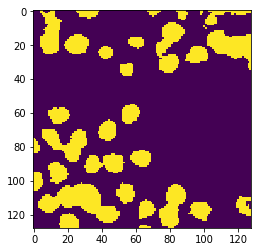

In [14]:
plt.imshow(preds[5,:,:,0])
plt.show()


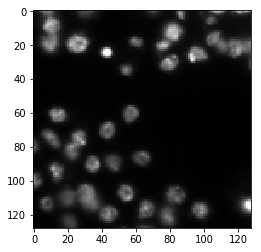

In [15]:
plt.imshow(X_test[5,:,:,:])
plt.show()

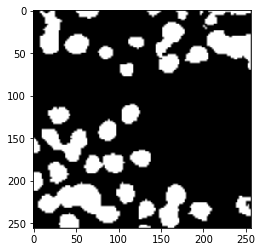

In [16]:
plt.imshow(final_mask[5][:,:,0], cmap='gray')
plt.show()

In [17]:
new_test_ids = []
rles = []

for n, id_ in enumerate(TEST_ID):
    rle = list(prob_to_rles(final_mask[n]))
    rles.extend(rle)
    new_test_ids.extend([id_]*len(rle))

## Submission

In [18]:
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('./submission/sub-dsbowl2018-test.csv', index=False)